# Hệ khuyến nghị. IUH 2025.
### Ngày 23/10/2025. Lab 7.
Mục tiêu: xây dựng hệ khuyến nghị hình ảnh đơn giản.

#### Ngô Hồng Thông
### 22649011

Recommender systems in online shopping help us deal with information overload by using both implicit and explicit user data, as well as internal system insights, to guide us towards the best product choices. Plus, these systems rely on detailed product catalogs and use images to turn potential buyers into loyal customers.

**Image-based recommendation systems** take this a step further by using visual similarities between items to improve product visibility, scalability, and performance. They seamlessly integrate with existing e-commerce platforms and aim to enhance the user experience and boost revenue by offering personalized recommendations and increasing business visibility.

### Understanding Image-Based Recommendation Systems

Image recommendation systems are designed to make our shopping experience better by providing personalized product suggestions based on visual data. Instead of just categorizing images, these systems focus on finding visually similar items to a given product image. They use large datasets, which includes around 44,000 images across 143 different categories such as T-shirts, jeans, and watches.ducts.

#### Key Techniques in Image Recommendation Systems

**Feature Extraction Methods**: 

(1) To extract low-level features from images, techniques like HSV histogram, edge detection, image texture analysis, and Histogram of Oriented Gradients (HOG) are used.

(2) For more complex features, advanced deep learning models such as VGG, Resnet, MobileNet, DenseNet, and Inception networks are employed.
  
**Classification and Retrieval**: 

(1) The CNN Classifier Based Retrieval (CCBR) technique classifies an input image and then generates product recommendations based on the predicted class.

(2) Some systems combine VGG and Resnet models to compute cosine similarity between images, which helps recommend the top K similar products.

### Building Image-Based Product Recommendation Systems

Image-based recommendation systems: 

(1) We can integrate image-based recommendation systems into e-commerce platforms using programming languages like Python. This allows us to recommend products that visually resemble the ones users have viewed

(2) 
Tools like Algolia’s LookingSimilar use machine learning to analyze visual content and provide compatible suggestions alongside traditional recommendation models, further enhancing these systems
.
These systems not only make it easier for users to find products similar to what they’re interested in, but also improve the accuracy of product recommendations, potentially leading to higher sales in e-commerce.

### Step 1: Importing Libraries
- *numpy*: Scientific computing and array operations.
- *pickle*: Serializing and deserializing Python objects.
- *tensorflow*: Building and training neural networks.
- *tensorflow.keras.applications.resnet50*: Pre-trained ResNet50 model for image classification.
- *tensorflow.keras.preprocessing.image*: Loading and preprocessing images.
- *tensorflow.keras.layers.GlobalMaxPool2D*: Global max pooling layer for spatial data.
- *sklearn.neighbors.NearestNeighbors*: Nearest Neighbors algorithm for finding closest data points.
- *os*: Interacting with the operating system, listing directory files.
- *numpy.linalg.norm*: Calculating the norm of a vector.
- *PIL (Python Imaging Library)*: Image handling and manipulation.
- *tkinter*: Creating GUI applications.
- *cv2 (OpenCV)*: Image processing and computer vision tasks

#### Cài đặt tensorflow và opencv-python

In [1]:
!pip install tensorflow


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install opencv-python


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import pickle as pkl
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalMaxPool2D
from sklearn.neighbors import NearestNeighbors
import os
from numpy.linalg import norm
from PIL import Image as PILImage, ImageTk
import tkinter as tk
import cv2

SV xem thêm dataset link và các mô tả đầy đủ tại đây: 

https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small

- **os.listdir(‘images’)** lists all files in the ‘images’ directory.
- **os.path.join(‘images’, file)** constructs the full path to each file.

Trong bài thực hành này, để xử lý nhanh, ta chỉ xét 630 ảnh trong số 44.440 ảnh của bộ dữ liệu gốc.

📁 Sử dụng thư mục ảnh: data/myntradataset\images
✅ Dataset có 629 sản phẩm có ảnh khớp.


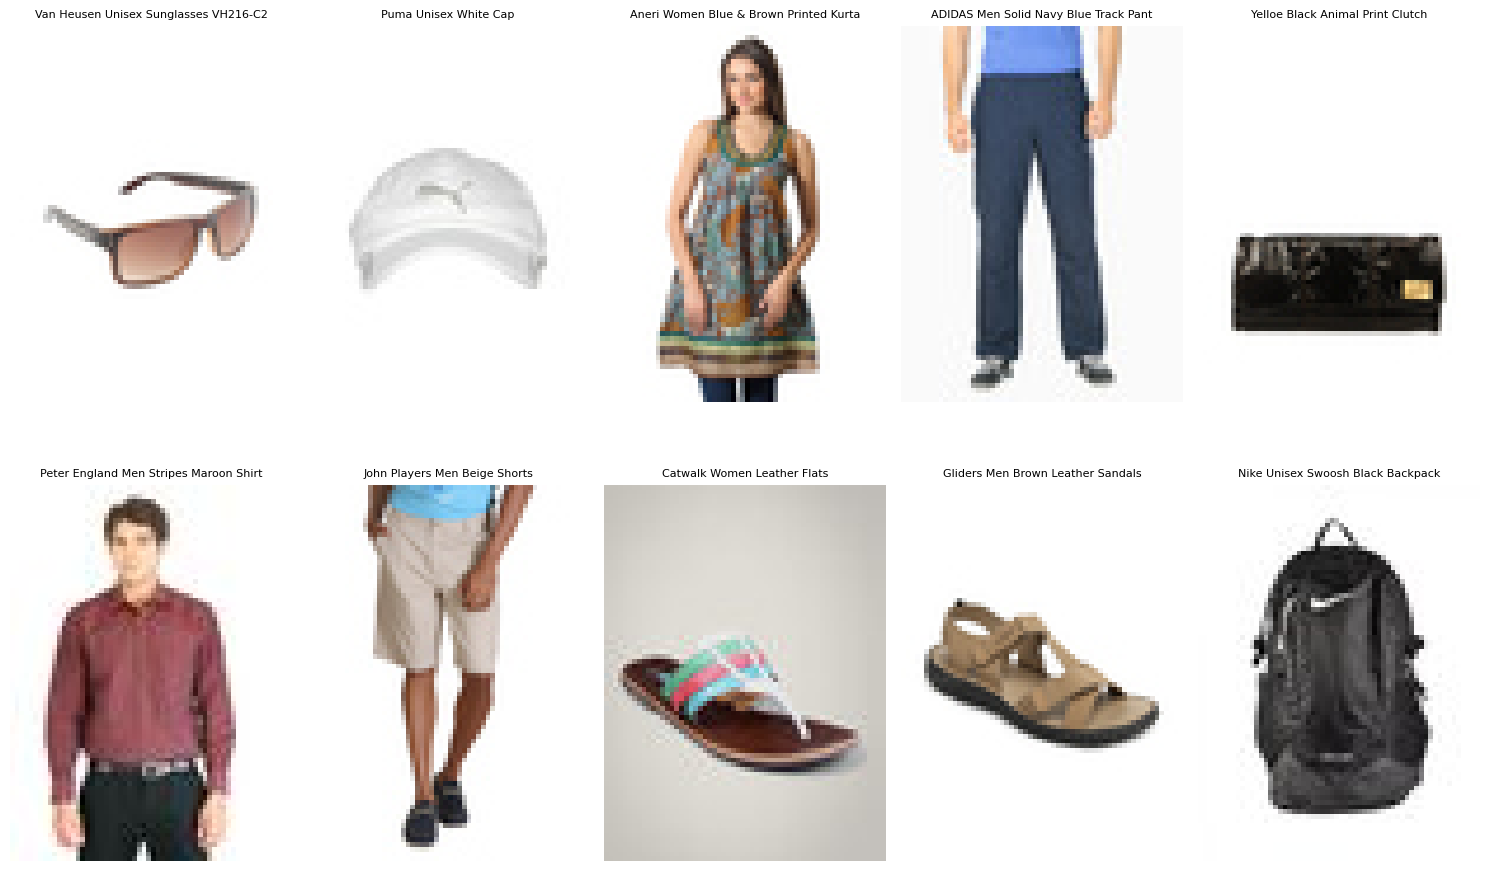

In [4]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# --- Đọc file styles.csv ---
csv_path = 'data/myntradataset/styles.csv'
df = pd.read_csv(csv_path)

# --- Xác định thư mục ảnh ---
base_dir = 'data/myntradataset'
possible_dirs = ['small_images', 'images']

image_dir = None
for d in possible_dirs:
    full_path = os.path.join(base_dir, d)
    if os.path.exists(full_path):
        image_dir = full_path
        break

if image_dir is None:
    raise FileNotFoundError("❌ Không tìm thấy thư mục chứa ảnh! Hãy kiểm tra lại đường dẫn.")

print(f"📁 Sử dụng thư mục ảnh: {image_dir}")

# --- Tạo danh sách file ảnh ---
filenames = [os.path.join(image_dir, file)
             for file in os.listdir(image_dir)
             if file.lower().endswith(('.jpg', '.jpeg', '.png'))]

# --- Tạo dict id -> image path ---
image_dict = {os.path.splitext(os.path.basename(f))[0]: f for f in filenames}

# --- Gắn cột image_path ---
df['image_path'] = df['id'].astype(str).map(image_dict)
df = df.dropna(subset=['image_path']).reset_index(drop=True)

print(f"✅ Dataset có {len(df)} sản phẩm có ảnh khớp.")

# --- Lấy ngẫu nhiên 10 ảnh ---
sample_df = df.sample(10, random_state=42)

# --- Hiển thị ảnh ---
plt.figure(figsize=(15, 10))
for i, (_, row) in enumerate(sample_df.iterrows()):
    plt.subplot(2, 5, i+1)  # 2 hàng, 5 cột
    try:
        img = Image.open(row['image_path'])
        plt.imshow(img)
        plt.title(row['productDisplayName'][:40], fontsize=8)  # cắt ngắn caption
        plt.axis('off')
    except Exception as e:
        plt.text(0.5, 0.5, f"Lỗi\n{e}", ha='center', va='center', fontsize=8)
plt.tight_layout()
plt.show()


#### Step 3: Load and Prepare the Model

Load the pre-trained ResNet50 model without the top layer and add a GlobalMaxPool2D layer to it.

- **ResNet50(weights=’imagenet’, include_top=False, input_shape=(224, 224, 3))**: Loading the ResNet50 model with pre-trained ImageNet weights, excluding the top fully connected layer, for input images of size 224x224x3.
- **model.trainable = False**: Freezes the ResNet50 layers to prevent their weights from being updated during training.
- **tf.keras.models.Sequential([model, GlobalMaxPool2D()])**: Creates a Sequential model that includes: The frozen ResNet50 model and A GlobalMaxPool2D layer to convert feature maps to a single feature vector per image.

In [5]:
model = ResNet50(weights='imagenet', include_top=False,
                 input_shape=(224, 224, 3))
model.trainable = False
model = tf.keras.models.Sequential([model, GlobalMaxPool2D()])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 2048)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

#### Step 4: Feature Extraction Function

- **img = image.load_img(image_path, target_size=(224, 224))**: Loads the image from the specified path and resizes it to 224×224 pixels.
- **img_array = image.img_to_array(img)**: Converts the loaded image to a NumPy array
- **img_expand_dim = np.expand_dims(img_array, axis=0)**: Adds an extra dimension to the array to represent the batch size, making it suitable for model inpu
- **img_preprocess = preprocess_input(img_expand_dim)**: Preprocesses the image array for ResNet50, scaling pixel values appropriately.
- **result = model.predict(img_preprocess).flatten()**: Uses the model to predict features from the preprocessed image and flattens the resulting feature map to a 1D array
- **norm_result = result / norm(result)**: Normalizes the feature vector to unit length.
- **return norm_result**: Returns the normalized feature vector.t.ector.ector.re vector.s

In [6]:
def extract_features_from_images(image_path, model):
    # Load the image with the target size of 224x224
    img = image.load_img(image_path, target_size=(224, 224))
    
    # Convert the image to a numpy array
    img_array = image.img_to_array(img)
    
    # Expand dimensions to match the model's input shape (batch size of 1)
    img_expand_dim = np.expand_dims(img_array, axis=0)
    
    # Preprocess the image for the ResNet50 model
    img_preprocess = preprocess_input(img_expand_dim)
    
    # Predict features using the model and flatten the result
    result = model.predict(img_preprocess).flatten()
    
    # Normalize the result vector
    norm_result = result / norm(result)
    
    # Return the normalized feature vector
    return norm_result

#### Step 5: Extract features from all images

- Initializes an empty list image_features.
- Iterates over each image file in filenames
- For each file, extracts features using **extract_features_from_images(file, model)**
- Appends the extracted features to image_features

In [7]:
# Extract features from all images
image_features = []
for file in filenames[:10]:
    image_features.append(extract_features_from_images(file, model))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


#### Step 6: Save Features and Filenames

- **pkl.dump(image_features, open(‘Images_features.pkl’, ‘wb’))**: Serializes the image_features list and writes it to a file named Images_features.pkl in binary mode (‘wb’).
- **pkl.dump(filenames, open(‘filenames.pkl’, ‘wb’))**: Serializes the filenames list and writes it to a file named filenames.pkl in binary mode (‘wb’).

In [8]:
pkl.dump(image_features, open('Images_features.pkl', 'wb'))
pkl.dump(filenames, open('filenames.pkl', 'wb'))

#### Step 7: Load Features and Filenames

- **image_features = pkl.load(open(‘Images_features.pkl’, ‘rb’))**: Opens the file Images_features.pkl in read-binary mode (‘rb’) and loads the serialized image_features list into memory.
- **filenames = pkl.load(open(‘filenames.pkl’, ‘rb’))**: Opens the file filenames.pkl in read-binary mode (‘rb’) and loads the serialized filenames list into memory.

In [9]:
image_features = pkl.load(open('Images_features.pkl', 'rb'))
filenames = pkl.load(open('filenames.pkl', 'rb'))

#### Step 8: Initialize Nearest Neighbors Model
- Sets **n_neighbors** to the smaller of 5 or the number of image features.
- Initializes a Nearest Neighbors model with Euclidean distance and brute-force search.
- Fits the model using the image_features data.

In [10]:
n_neighbors = min(5, len(image_features))
neighbors = NearestNeighbors(
    n_neighbors=n_neighbors, algorithm='brute', metric='euclidean')
neighbors.fit(image_features)

NearestNeighbors(algorithm='brute', metric='euclidean')

#### Step 9: Extract Features from single input image

The code basically grabs the feature vector of the input image *1697.jpg* using the **extract_features_from_images** function along with a pre-trained model. After that, it taps into the Nearest Neighbors model to hunt down the most similar images from a dataset by comparing their feature vectors. The neighbors.kneighbors method comes into play here, returning the distances and indices of these nearest neighbors, which helps to spot visually similar images.

In [11]:
filenames[:10]

['data/myntradataset\\images\\10000.jpg',
 'data/myntradataset\\images\\10001.jpg',
 'data/myntradataset\\images\\10002.jpg',
 'data/myntradataset\\images\\10003.jpg',
 'data/myntradataset\\images\\10004.jpg',
 'data/myntradataset\\images\\10005.jpg',
 'data/myntradataset\\images\\10006.jpg',
 'data/myntradataset\\images\\10007.jpg',
 'data/myntradataset\\images\\10008.jpg',
 'data/myntradataset\\images\\10009.jpg']

In [12]:
# Thay vì dùng path cố định, dùng file từ danh sách filenames
if len(filenames) > 0:
    test_image_path = filenames[0]  # Lấy ảnh đầu tiên
    print(f"Testing with: {test_image_path}")
    
    input_image = extract_features_from_images(test_image_path, model)
    distance, indices = neighbors.kneighbors([input_image])
    
    print(f"Distances: {distance}")
    print(f"Similar images: {[filenames[i] for i in indices[0]]}")
else:
    print("Không có file ảnh nào trong danh sách!")

Testing with: data/myntradataset\images\10000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Distances: [[0.         0.75810051 0.77916199 0.84764183 0.91994321]]
Similar images: ['data/myntradataset\\images\\10000.jpg', 'data/myntradataset\\images\\10003.jpg', 'data/myntradataset\\images\\10001.jpg', 'data/myntradataset\\images\\10002.jpg', 'data/myntradataset\\images\\10005.jpg']


c:\Users\thong\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\thong\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\thong\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\thong\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\thong\AppData\Local\Programs\Python\Python310\lib\subp

In [13]:
# Example: Extract features from a single input image and find nearest neighbors
input_image = extract_features_from_images('data/myntradataset/images/1541.jpg', model)
distance, indices = neighbors.kneighbors([input_image])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


#### Step 10: Define Recommendation Function with GUI

The **get_image_recommendations** function does a cool thing – it gives you image recommendations. First, it takes the input image and extracts its feature vector using a pre-trained model. Then, it uses a Nearest Neighbors model to find the most similar images. The function also creates a tkinter GUI window called **Image Recommendations** to show you these similar images. It reads each recommended image, resizes it, and converts it to a format that works with tkinter using OpenCV and PIL. After that, it displays the images side by side in the window, and the tkinter event loop kicks in to make the GUI show up. This function is like a superhero that combines feature extraction, finding similar images, and making it all easy to use for you.

In [14]:
import PIL
def get_image_recommendations(image_path, model, neighbors, filenames):
    input_image = extract_features_from_images(image_path, model)
    distance, indices = neighbors.kneighbors([input_image])
    root = tk.Toplevel()
    # root = tk.Tk()
    root.title("Image Recommendations")

    for idx in indices[0]:
        recommended_image = filenames[idx]
        img = cv2.imread(recommended_image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = PILImage.fromarray(img)
        img = img.resize((200, 200), PIL.Image.LANCZOS)
        img_tk = ImageTk.PhotoImage(img)

        label = tk.Label(root, image=img_tk)
        label.image = img_tk
        label.pack(side="left", padx=5, pady=5)

    root.mainloop()

In [15]:
#### Trần Thị Huyền
### 22657821

#### Step 11 :Example Usage
Call the recommendation function with an example image

In [16]:
get_image_recommendations('data/myntradataset/images/1541.jpg', model, neighbors, filenames)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


KeyboardInterrupt: 

### Applications of Image Recommendation Systems
- **Enhancing E-commerce Search and Tagging**: We make searching for products online a breeze by organizing and tagging keywords from uploaded images. This helps boost sales and makes it easier for customers to find what they’re looking for.
- **Social Media Integration**: We take advantage of image recognition technology to suggest products on popular platforms like Pinterest and Facebook. This gives businesses a boost in their digital marketing efforts and helps them reach a wider audience.
- **Personalized User Experiences**: Our AI-driven systems offer instant and personalized product suggestions based on how users behave. This means that each customer gets recommendations that are tailored to their interests, making their shopping experience more relevant and enjoyable.
- **Travel and Leisure Applications**: We provide personalized travel recommendations by analyzing photos from social networks. This allows us to enhance the user experience by suggesting destinations and activities that match their interests and preferences.

### Conclusion

Image-based recommendation systems are revolutionizing e-commerce by improving engagement and boosting sales. By leveraging visual data, these systems provide personalized experiences, reduce search overload, and promote product discovery. They play a crucial role in meeting consumer demand for personalized and visually engaging experiences, offering businesses innovative growth opportunities. The widespread adoption of these technologies promises unmatched benefits, signaling a shift towards more intuitive digital interactions.